Using device: cuda:1
Loading segmentation model from: /workspace/jke_capston/synthesis/seg_model.pth
Loading cloth image: /workspace/jke_capston/synthesis_input/clothing-1.png
Loading person image: /workspace/jke_capston/synthesis_input/model-1.png
Generating segmentation mask...
Applying erosion (kernel=5, iterations=2)...
Initializing CatVTON pipeline...


An error occurred while trying to fetch booksforcharlie/stable-diffusion-inpainting: booksforcharlie/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 63630.40it/s]


Downloaded zhengchong/CatVTON to /root/.cache/huggingface/hub/models--zhengchong--CatVTON/snapshots/2969fcf85fe62f2036605716f0b56f0b81d01d79
Running CatVTON inference...


100%|██████████| 15/15 [00:00<00:00, 16.52it/s]


Saving results...
Processing result 0, mode: RGB
Saved: total_output/model-1.png+clothing-1.png/model-1/0.png

Inference time: 25.01 seconds
Output directory: total_output/model-1.png+clothing-1.png/model-1


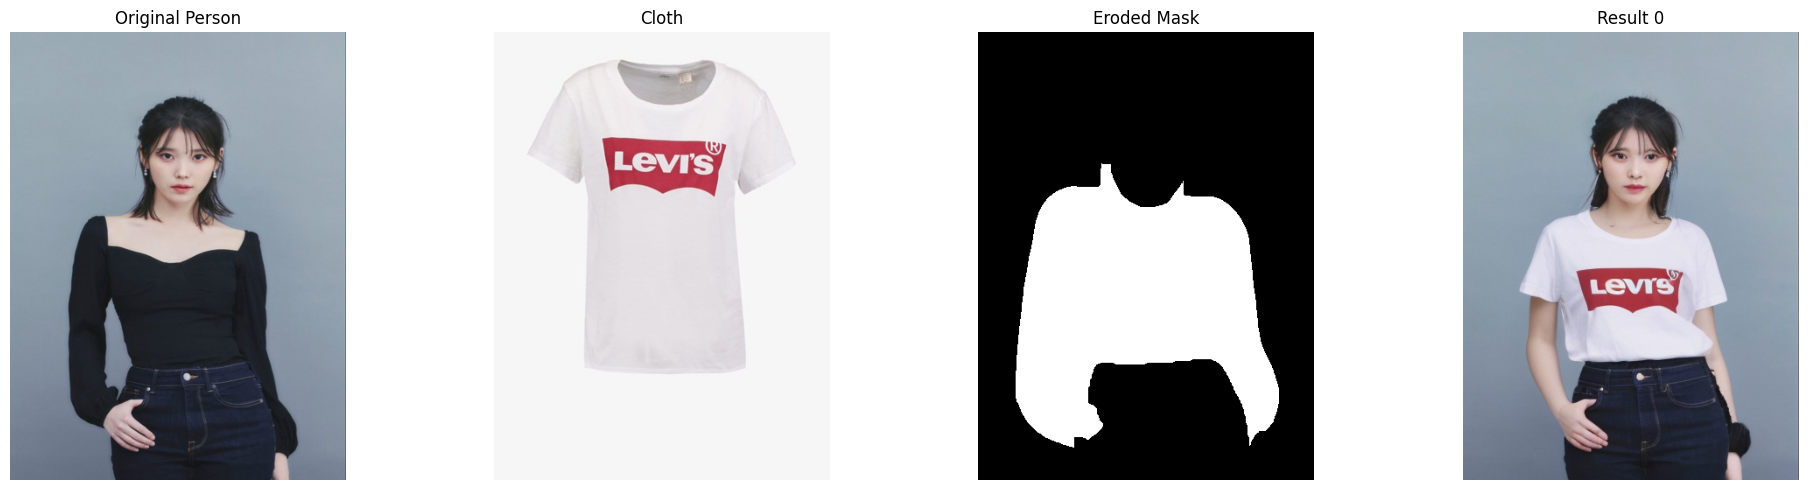

In [3]:
import torch
import time
import segmentation_models_pytorch as smp
from PIL import Image
import os
from model.pipeline import CatVTONPipeline
from diffusers.image_processor import VaeImageProcessor
import matplotlib.pyplot as plt
import cv2
import numpy as np

# "mix": "mix-48k-1024",
# "vitonhd": "vitonhd-16k-512",
# "dresscode": "dresscode-16k-512",

# Configuration
config = {
    # Device settings
    'device': None,  # None for auto-detect, or specify 'cuda:0', 'cuda:1', 'cpu'
    
    # Segmentation model settings
    'backbone': 'resnet50',
    'seg_model_path': '/workspace/jke_capston/synthesis/seg_model.pth',
    
    # Input paths
    # 아이유 - 
    # 터틀넥, 반팔1, 반팔2, 반팔4, 긴팔4, 긴팔5, 긴팔6 
    'cloth_path': '/workspace/jke_capston/synthesis_input/clothing-1.png',
    'img_path': '/workspace/jke_capston/synthesis_input/model-1.png',
    
    # Pipeline settings
    'attn_ckpt_version': 'vitonhd',
    'attn_ckpt': 'zhengchong/CatVTON',
    'base_ckpt': 'booksforcharlie/stable-diffusion-inpainting',
    'weight_dtype': 'fp16',  # 'no', 'fp16', or 'bf16'
    'skip_safety_check': True,
    
    # Generation parameters
    # 3402
    'seed': None,
    'num_inference_steps': 15,
    'guidance_scale': 2.5,
    'width': 384,
    'height': 512,
    
    # Segmentation size
    'seg_width': 384,
    'seg_height': 512,
    
    # Morphology settings
    'erode_kernel_size': 5,  # 커널 크기 (홀수여야 함)
    'erode_iterations': 2,    # 침식 반복 횟수
    
    # Output settings
    'output_dir': 'total_output'
}

# Device setup
if config['device'] is None:
    device = "cuda:1" if torch.cuda.is_available() else "cpu"
else:
    device = config['device']

print(f"Using device: {device}")

# Segmentation model creation
segmodel = smp.Unet(config['backbone'], classes=1, activation='sigmoid').to(device)

# Load segmentation model
print(f"Loading segmentation model from: {config['seg_model_path']}")
state_dict = torch.load(config['seg_model_path'], map_location=device, weights_only=False)
segmodel.load_state_dict(state_dict)
segmodel = segmodel.to(device)
segmodel.eval()

# VaeImageProcessor
preprocessor = VaeImageProcessor(vae_scale_factor=8)

# Load and preprocess cloth image
print(f"Loading cloth image: {config['cloth_path']}")
cloth = Image.open(config['cloth_path']).convert("RGB")
cloth = cloth.resize((config['width'], config['height']))

# Load and preprocess person image
print(f"Loading person image: {config['img_path']}")
img = Image.open(config['img_path']).convert("RGB")
img = img.resize((config['width'], config['height']))

# Generate mask using segmentation model
print("Generating segmentation mask...")
start_time = time.time()

tensor_img = preprocessor.preprocess(img, height=config['seg_height'], width=config['seg_width'])
tensor_img = tensor_img.to(device)

with torch.no_grad():
    logits = segmodel(tensor_img)
    mask = (logits > 0.5).float()

mask_np = mask.squeeze(0).squeeze(0).cpu().numpy()

# PIL 이미지로 변환
mask_pil = Image.fromarray((mask_np * 255).astype('uint8'), mode='L')
mask_pil = mask_pil.resize((config['width'], config['height']), resample=Image.NEAREST)

# Apply erosion
print(f"Applying erosion (kernel={config['erode_kernel_size']}, iterations={config['erode_iterations']})...")
mask_np_resized = np.array(mask_pil)
kernel = np.ones((config['erode_kernel_size'], config['erode_kernel_size']), np.uint8)
eroded_mask = cv2.erode(mask_np_resized, kernel, iterations=config['erode_iterations'])
mask_pil = Image.fromarray(eroded_mask, mode='L')

# Initialize CatVTON pipeline
print("Initializing CatVTON pipeline...")
weight_dtype_map = {
    "no": torch.float32,
    "fp16": torch.float16,
    "bf16": torch.bfloat16,
}

pipeline = CatVTONPipeline(
    attn_ckpt_version=config['attn_ckpt_version'],
    attn_ckpt=config['attn_ckpt'],
    base_ckpt=config['base_ckpt'],
    weight_dtype=weight_dtype_map[config['weight_dtype']],
    device=device,
    skip_safety_check=config['skip_safety_check']
)

# Set up generator
if config['seed'] is not None :
    generator = torch.Generator(device=device).manual_seed(config['seed'])
else :
    generator = torch.Generator(device=device)

# Create output directory
output_dir = os.path.join(
    config['output_dir'], 
    f"{os.path.basename(config['img_path'])}+{os.path.basename(config['cloth_path'])}"
)
person_name = os.path.splitext(os.path.basename(config['img_path']))[0]
person_dir = os.path.join(output_dir, person_name)
os.makedirs(person_dir, exist_ok=True)

# Run inference
print("Running CatVTON inference...")
results = pipeline(
    img,
    cloth,
    mask_pil,
    num_inference_steps=config['num_inference_steps'],
    guidance_scale=config['guidance_scale'],
    height=config['height'],
    width=config['width'],
    generator=generator
)

# Save results
print("Saving results...")
for idx, result in enumerate(results):
    print(f"Processing result {idx}, mode: {result.mode}")
    
    output_path = os.path.join(person_dir, f"{idx}.png")
    result.save(output_path)
    print(f"Saved: {output_path}")

end_time = time.time()
print(f"\nInference time: {end_time - start_time:.2f} seconds")
print(f"Output directory: {person_dir}")

# Visualize results with matplotlib
num_results = len(results)
fig, axes = plt.subplots(1, num_results + 3, figsize=(5 * (num_results + 3), 5))

# Show original person image
axes[0].imshow(img)
axes[0].set_title('Original Person')
axes[0].axis('off')

# Show cloth image
axes[1].imshow(cloth)
axes[1].set_title('Cloth')
axes[1].axis('off')

# Show mask
axes[2].imshow(mask_pil, cmap='gray')
axes[2].set_title('Eroded Mask')
axes[2].axis('off')

# Show results
for idx, result in enumerate(results):
    axes[idx + 3].imshow(result)
    axes[idx + 3].set_title(f'Result {idx}')
    axes[idx + 3].axis('off')

plt.tight_layout()
plt.show()

In [2]:
from diffusers import StableDiffusionUpscalePipeline 
import torch
upscaler = StableDiffusionUpscalePipeline.from_pretrained(
            "stabilityai/stable-diffusion-x4-upscaler",
            torch_dtype=torch.float16
        ).to(device)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/envs/jke_capston/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]


NameError: name 'device' is not defined